# **Градиентный спуск и методы его оптимизации**

### ***Содержание***

* 1. [Введение](#intro)
* 2. [Градиентный спуск в рамках матанализа](#grad_desc_in_math)
  * 2.1. [Условие задачи](#task_descrip)
  * 2.2. [Функция потерь](#loss_func)
  * 2.3. [Градиентный спуск](#basics_grad_desc)
  * 2.4. [Математическая интерпретация функции потерь](#math_loss_func)
* 3. Градиентный спуск в рамках машинного обучения
  * 3.1. Пример кода
  * 3.2. Недостатки градиентного спуска
      * 3.2.1. Нахождение ложного локального минимума
      * 3.2.2. Высокая асимптотика алгоритма
* 4. Методы оптимизации градиентного спуска
  * 4.1. Определение начальной координаты
  * 4.2. Метод нормирования градиента (clip gradient)
  * 4.3. Стохастический градиентный спуск
* 5. Задача аппроксимации линейной функции
  * 5.1. Условие задачи
  * 5.2. Алгебраическое решение
  * 5.3. Решение с помощью градиентного спуска
  * 5.4. Оптимизированное решение с помощью стохастического градиентного спуска
* 6. Заключение

## Введение
<a id='intro'></a>

Большинство задач машинного обучения, как правило, представляют собой задачи или классификации, или регрессии. Ярким примером задач последнего типа является задача аппроксимации линейной функции.

Ниже будет рассмотрено применение самого популярного метода оптимизации для решения данной задачи. Речь пойдёт о градиентном спуске и методах его оптимизации.

## Градиентный спуск в рамках матанализа
<a id='grad_desc_in_math'></a>

### Условие задачи
<a id='task_descrip'></a>

Рассмотрим группу точек на двумерной плоскости. Предположим, что данные связаны с ростом и весом группы студентов. Мы пытаемся предсказать какую-то связь между этими величинами, чтобы впоследствии предсказать вес некоторых новых студентов. Это, по сути, простой пример контролируемого машинного обучения.

Проведем произвольную прямую в пространстве, которая пересекает некоторые точки. Уравнение этой прямой: $y = kx + b$, где $k$ - коэффициент угла наклона, а $b$ - перемещение по оси $Oy$ (см. *Рис. 1*).

***Рис. 1: Задача аппроксимации линейной функции***
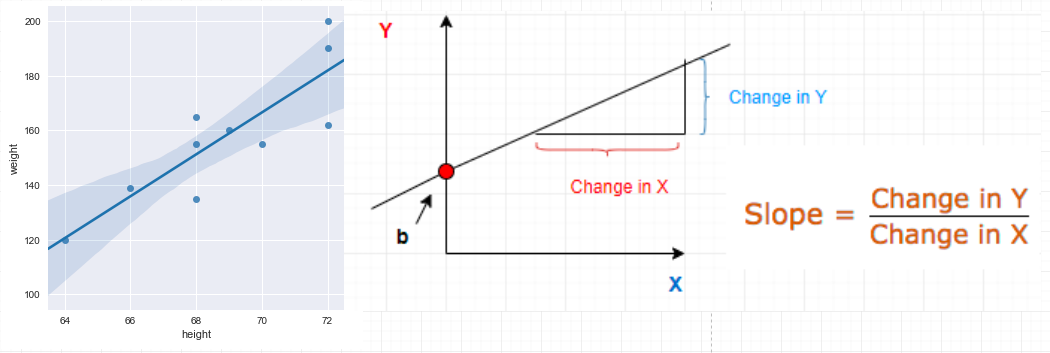

Учитывая уже известный набор входных данных (в нашем случае $x$-координаты) и соответствующие им выходные данные ($y$-координаты), модель пытается сделать прогнозы для нового набора входных данных (см. *Рис. 2*).

***Рис. 2: Схема модели машинного обучения***

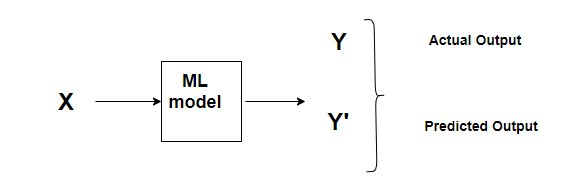

### Функция потерь
<a id='loss_func'></a>

Однако возникает вопрос: насколько "хороша" модель, иначе говоря, насколько точное сравнительно с реальностью предсказание она сделала? Логично предположить, что данная ошибка вычисляется тривиально:

$Error = \frac{\sum_{i=1}^{N} (Y'_i - Y_i)^2}{N}$, где $N$ - кол-во точек, $Y'_i$ - предсказанное значение, а $Y_i$ - входное значение.

В машинном обучении данная функция называется **функция потерь** или **функция стоимости** (сделаем допущение: функция потерь и функция стоимости - равнозначные термины).

**Цель** практически любого алгоритма машинного обучения - **минимизировать функцию потерь**.

Стоит отдельно рассмотреть вопрос, почему функция потерь среднеквадратичная, а не абсолютная. Дело в том, что квадрат разности значений облегчает процесс оптимизации. Действительно, чтобы оптимизировать функцию под определённые значения, нужно вычислить первую производную функции стоимости, а вычислить производную от абсолютных значений гораздо сложнее, нежели от квадратов. Кроме того, квадрат разности увеличивает различие ошибки, таким образом, делая неверные предсказания более выраженными, чем верные.

Рассмотрим график функции $y = x^2$ в декартовой системе координат (см. *Рис. 3*).

***Рис. 3: График функции $y = x^2$***

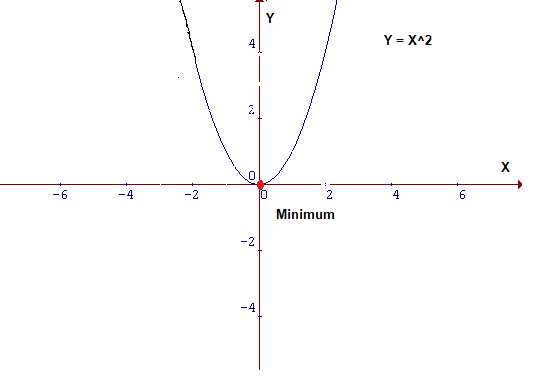

Чтобы достичь минимума функции, необходимо найти такое значение $x$, чтобы значение $y$ было минимально (красная точка на *Рис. 3*).

Исходя из двумерности графика на *Рис. 3*, найти минимум функции не составляет труда. Однако функция далеко не всегда может располагаться в двумерном пространстве, что значительно усложняет процесс нахождения минимума. И именно в таких случаях в целях нахождения минимума функции применяется алгоритм, несущий название **градиентный спуск**.

### Градиентный спуск
<a id='basics_grad_desc'></a>

Градиентный спуск - итеративный алгоритм оптимизации, применяющийся в большинстве случаев при оптимизации весов нейронной сети.

***Рис. 4: Возможные варианты спуска***

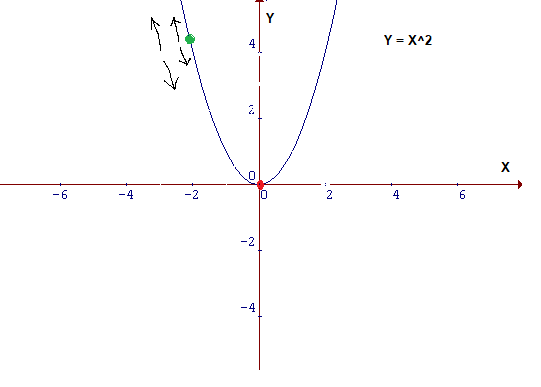

Рассмотрим *Рис. 4*. Представим, что мы находимся в зелёной точке и хотим спустится с холма в низину. Для достижения нашей цели следует определиться с двумя вопросами:

* в какую сторону идти (влево или вправо);
* как идти (короткими или длинными шагами).

Для решения этих вопросов в алгоритме градиентного спуска используются производные. Таким образом, если в точке $x$ существует производная, то существует и направление, при движении в котором алгоритм достигнет минимума.

Рассмотрим *Рис. 5*.

Пусть, касательные, проведённые через зелёную и синию точки, обозначаются $a$ и $b$ соответственно. Тогда можно обратить внимание на различный угол наклона касательных: несмотря на то, что обе касательные идут в одном направлении (вниз), угол наклона $a$ к графику функции более "крутой", чем угол наклона $b$. Из этого следует, что для достижения локального минимума из синей точки понадобиться сделать **строго меньше шагов**, чем из зелёной точки.

***Рис. 5: Касательные к графику $y = x^2$***

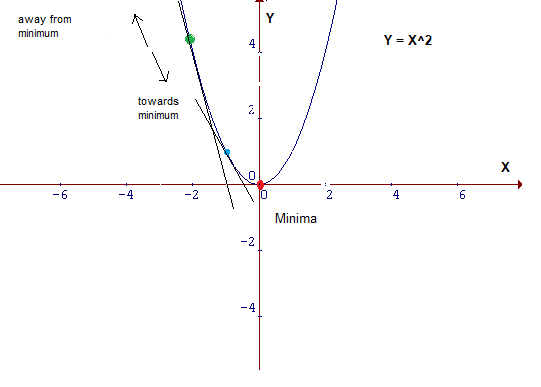

### Математическая интерпретация функции потерь
<a id='math_loss_func'></a>

В течение градиентного спуска параметры функции $y = kx + b$ ($k$ и $b$) изменяются на какое-то значение. Пусть это значение будет $\beta$. Тогда:

$k_1 = k_0 - \beta k_0, b_1 = b_0 - \beta b_0$ (1) ->

-> $Error = \frac{\sum_{i=1}^{N} (Y'_i - Y_i)^2}{N}$ ->

-> $J(k, b) = \frac{\sum_{i=1}^{N} (Y'_i - Y_i)^2}{N}$ ->

-> $J(k, b) = \frac{\sum_{i=1}^{N} (Error_i)^2}{N}, Error_i = (Y'_i - Y_i)^2$ ->

-> ... ->

-> $\frac{dJ(k, b)}{dk} = Error * x * \alpha,$

$\frac{dJ(k, b)}{db} = Error * \alpha$, где $\alpha$ - коэффициент обучения, определяющий, какой длины нужно сделать шаг. ->

-> Так как (1) ->

-> $k_1 = k_0 - Error * x * \alpha$

$b_1 = b_0 - Error * \alpha$,

где $k_0, b_0$ - предыдущие значения параметров, а $k_1, b_1$ - следующие значения параметров.